<font size=6> Non-Markovian Data Generating Processes</font>

This notebook will be used to generate fractional gaussian noise (and fractional brownian motion, the cumulative sum of the gaussian noise). Given by the following function, where H is the Hurst exponent, and cov(s,t) represents the auto-covariance of the process, covariance with itself at time lag between s & t, 

<center>$\huge cov(s,t) = \frac{1}{2} \left( t^{2H} + s^{2H} - |t-s|^{2H} \right)$</center>


<font size=5> Hurst exponent </font>

The Hurst exponent is a statistical measure that can be used to quantify the degree of long-term memory or persistence in a time series. It is often used to determine whether a time series is mean-reverting (i.e., returns to its mean value over time) or trend-following (i.e., exhibits long-term trends).

In general, a Hurst exponent of 0.5 indicates that the time series is a random walk with no long-term memory, while a Hurst exponent greater than 0.5 indicates that the series exhibits trend-following behavior, and a Hurst exponent less than 0.5 indicates that the series has negative auto-correlations -- the sign of the return switches back and forth as in 'rough volatility' and eventually mean reverts rather than trending.

<font size=5> Install pyeeg for the hurst function </font>

In [1]:
%pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-k1wgp147
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-k1wgp147
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28113 sha256=ec9e1097d01f2b028e87089d8b05053b31a641290e5741ca222de93c346dabb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-mintqz65/wheels/b0/23/e4/703c908bda656959957029fa145879aa79307b2545a2ef0271
Successfully built pyeeg
  Attempting uninstall: pyeeg
    Found existing installation: pyeeg 0.0.2
    Uninstalling pyeeg-0.0.2:
      Successfully uninstalled pyeeg-0.0.2
Note: you may need to restart the kernel to use updated packages.


<font size=5>Create fBm Class for Multifractional Stochastic Process</font>

Defining a class that creates 2D multivariate fractional gaussian noise with a drift parameter and sigma parameter which scales the variance of the process.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import pyeeg 

from model.fgn import fractional_gaussian_covariance_series
from copulas.visualization import compare_3d

class FBm():

    def generate_gaussian_fBm(self, 
                              hurst1: float, 
                              hurst2: float, 
                              corr: float, 
                              size: int, 
                              sigmas: list = [0.0, 0.0], 
                              drifts: list = [0.0, 0.0]):

        means = np.zeros(2 * size)     
        means[0:size] = means[0:size] + drifts[0]
        means[size:] = means[size:] + drifts[1]
                         
        cov = fractional_gaussian_covariance_series(size, hurst1, hurst2, corr, sigmas[0], sigmas[1]) 

        result = np.random.multivariate_normal(means, cov)
        result_ts = np.ndarray((2, size))
        result_ts[0] = result[0:size]
        result_ts[1] = result[size:]

        return np.cumsum(np.insert(result_ts, 0, 0, axis=1), axis=1) 
    
    def hurst(self, X):
        return pyeeg.hurst(X) 

<font size=5>Generate FBm Time Series</font>

Generating a Monte Carlo simulation. 

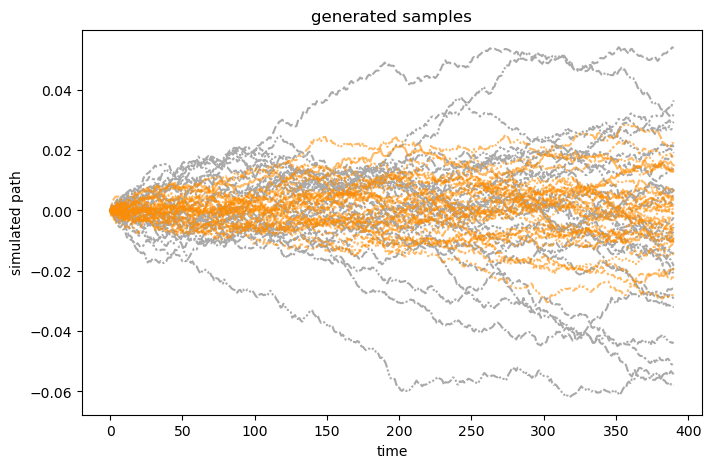

In [7]:
# Gather up log returns 
import pandas as pd 
tlt = pd.read_csv('./data/TLT_sample.csv')
tlt['marketClose'] = tlt['marketClose'].apply(np.log).diff().dropna()

# Empirical mean and standard deviation of the sample, and correlation for the simulation
mean0 = np.mean(tlt['marketClose']) 
mean1 = 0.0
std0 = np.std(tlt['marketClose']) 
std1 = np.std(tlt['marketClose']) 
corr = 0.0

# Instantiate the class, get the Hurst exponent for the empirical data 
fbm = FBm()
hurst1 = fbm.hurst(tlt['marketClose'].dropna().values)
hurst2 = 0.5

fig, ax = plt.subplots(figsize=(8, 5
                              ))
# Generate correlated gaussian noise and cumulative sum brownian motion 
# Run MC
sims1 = pd.DataFrame()
sims2 = pd.DataFrame()
size = len(tlt['marketClose']) - 1
for t in range(30): 
    fgn = fbm.generate_gaussian_fBm(hurst1, hurst2, corr, size, sigmas=[std0, std1], drifts=[mean0, mean1])
    sims1[str(t)] = fgn[0]
    sims2[str(t)] = fgn[1]
    
sns.lineplot(data=sims1, legend=None, palette=['darkgrey'], ax=ax)
sns.lineplot(data=sims2, legend=None, palette=['darkorange'], alpha=0.6, ax=ax)
plt.xlabel('time')
plt.ylabel('simulated path')
plt.title('generated samples')
plt.show() 

<font size=5>Visualize a Sample</font>

Visualizing a sample from the Monte Carlo sim. The empirical Hurst exponent of the data dictates the Hurst exponent of the simulation represented by from_empirical_HurstExp lines. One line uses a Hurst exponent of 0.5 statically to provide a baseline. 

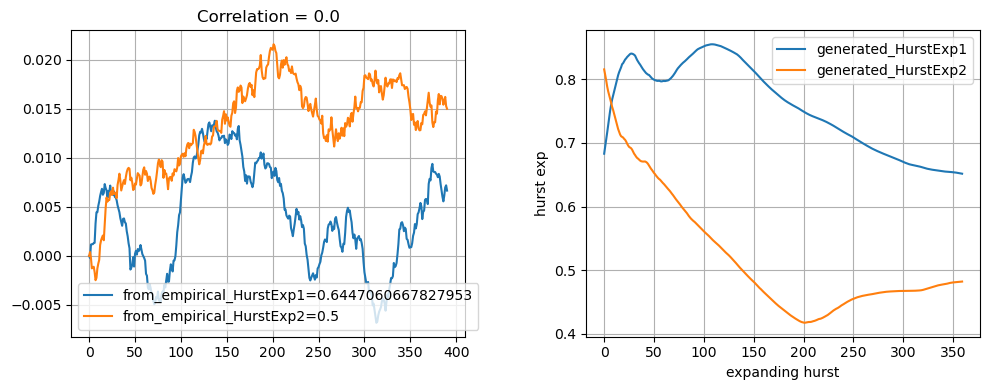

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Diff a sample of the simulated data 
diffed0=np.diff(sims1['0'])
diffed1=np.diff(sims2['0'])

# Compare the synthetic data to the empirical data 
ax1.plot(sims1['0'], label=f"from_empirical_HurstExp1={hurst1}")
ax1.plot(sims2['0'], label=f"from_empirical_HurstExp2={hurst2}")
ax1.set_title(f"Correlation = {corr}")
ax1.grid(True)
ax1.legend()
ax2.plot([ fbm.hurst(diffed0[:X]) for X in range(30, len(diffed0)) ], label=f"generated_HurstExp1")
ax2.plot([ fbm.hurst(diffed1[:X]) for X in range(30, len(diffed1)) ], label=f"generated_HurstExp2")
ax2.set_xlabel('expanding hurst')
ax2.set_ylabel('hurst exp')
ax2.grid(True)
ax2.legend()

fig.tight_layout()
plt.show()

<font size=5> Auto-Correlation Plot </font>

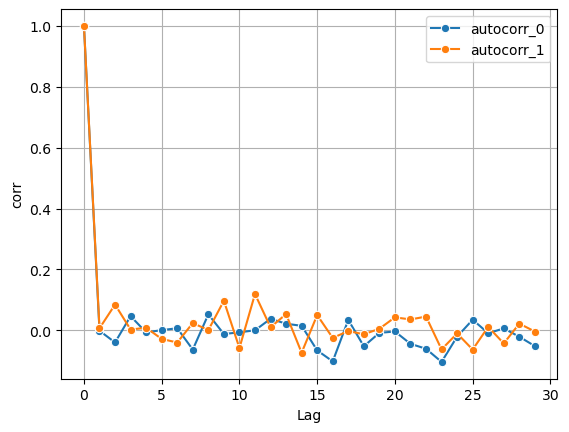

In [9]:

# Get the auto-correlation decay of the simulated data 
autocorr_df = pd.DataFrame()
autocorr_df['decay_0'] = np.diff(sims1['0'])
autocorr_df['decay_1'] = np.diff(sims2['1'])
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_0'], range(0, 30)), label='autocorr_0', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_1'], range(0, 30)), label='autocorr_1', marker='o')
plt.xlabel('Lag')
plt.ylabel('corr')
plt.grid(True)
plt.show()


<font size=5> 3D Plot </font>

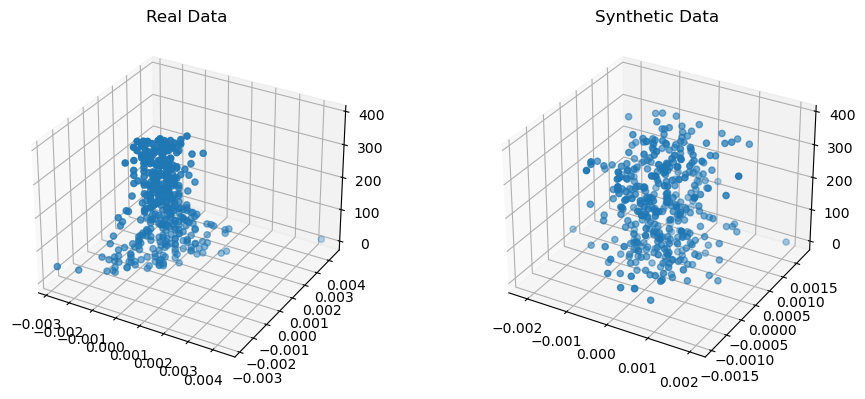

In [10]:

# 3D Plots
three_df = pd.DataFrame() 
three_df['x'] = np.diff(sims1['0'])
three_df['y'] = np.diff(sims2['1'])
three_df['z'] = range(size)

orig_three_df = pd.DataFrame()
orig_three_df['x'] = tlt['marketClose'].dropna().values
orig_three_df['y'] = tlt['marketClose'].dropna().values
orig_three_df['z'] = range(len(tlt)-1)

compare_3d(orig_three_df, three_df)